<style>
.rendered_html * + p, .rendered_html p {
    text-align:justify;
}
.print {
    display:none;
}
.highlight {
    background:white;
}
@media print {
 a[href]:after {
     content: ""
 }
 .noprint {
  display:none
  }
  .print {
        display:block;
    }
}
</style>
<head>
    <base target="_blank">
</head>


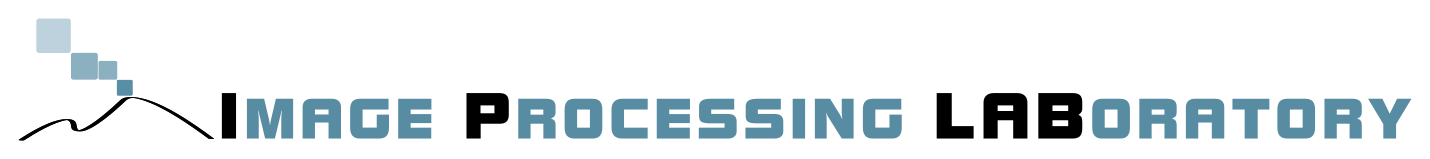

<center><h2>Deep Learning - A.A. 2021-2022</h2></center>
<center><h3>Reti Ricorrenti</h3></center>
<br>
<center>Antonino Furnari - <a href="http://www.antoninofurnari.it/" target="_blank">http://www.antoninofurnari.it/</a> - <a href="mailto:furnari@dmi.unict.it">furnari@dmi.unict.it</a> </center>
<center>Giovanni Maria Farinella - <a href="http://www.dmi.unict.it/farinella/" target="_blank">http://www.dmi.unict.it/farinella/</a> - <a href="mailto:gfarinella@dmi.unict.it">gfarinella@dmi.unict.it</a> </center>

In questo laboratorio vedremo come costruire ed allenare un modello di tipo LSTM. I modelli visti finora analizzano ciascun dato in input in maniera totalmente indipendente e pertanto essi sono limitati quando è necessario processare delle sequenze di dati. Si pensi ad esempio a un video: una CNN può essere utilizzata per analizzare ciascun frame del video, tuttavia l'analisi di ciascun frame sarà totalmente indipendente rispetto agli altri frame e pertanto il modello non potrà modellare le interdipendenze temporali tra frame adiacenti (ad esempio due frame adiacenti verosimilmente contengon scene e oggetti simili). Per risolvere questo problema, sono state proposte le reti ricorrenti (Recurrent Neural Networks - RNN). 

Una rete ricorrente può essere utilizzata per analizzare una sequenza di dati di lunghezza non fissa. Con riferimento al fatto che i diversi elementi della sequenza sono disponibili in istanti temporali diversi, ciascun passo della computazione è generalmente detto "time-step". Per permettere questo tipo di analisi, il modello mantiene un vettore di "memoria" che viene passato da un time-step al successivo.

Una rete ricorrente può essere utilizzata per implementare diversi schemi di processing di sequenze, come mostrato nella seguente figure:

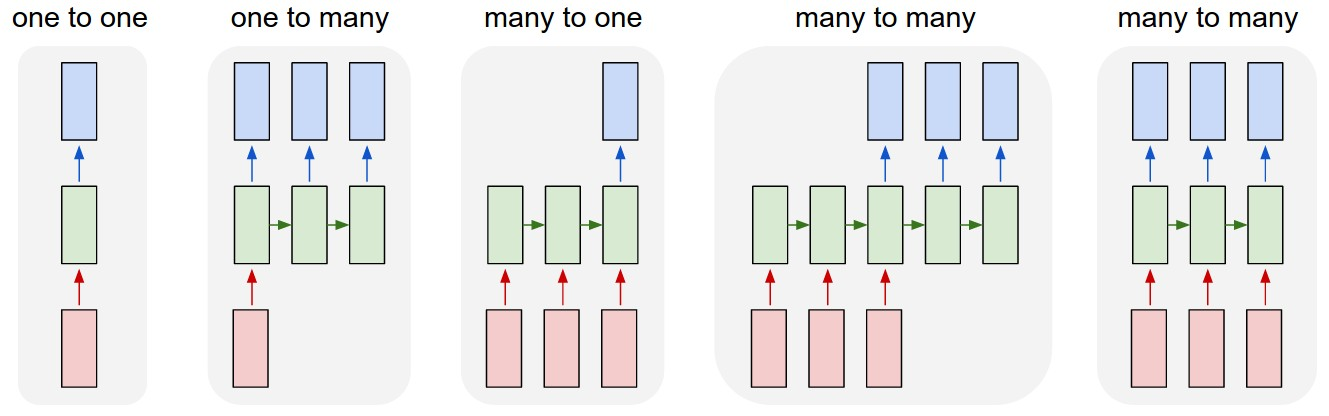

In particolare:

 * One-to-one: è il tipo di processing visto finora, in cui i dati non sono cosniderati come parte di una sequenza;
 * One-to-many: si tratta di task di "generazione" di sequenze, in cui l'input è un singolo data point, mentre l'output è una sequenze. Ad esempio: generazione di una parola data la sua prima lettera;
 * Many-to-one: l'input è una sequenza (ad esempio una stringa di caratteri), l'output è un valore scalare. Ad esempio: classificazione di testo;
 * Many-to-many 1: l'input è una sequenza, l'output è una sequenza. Ad esempio: traduzione di testo da una lingua a un'altra;
 * Many-to-many 2: Simile allo schema precedente, ma l'output viene generato passo dopo passo senza attendere di aver prima processato l'intera sequenza di input. Ad esempio: Part of Speech tagging, ovvero classificaizione di ciascuna parola del testo per indicare il ruolo all'interno della frase (es. nome, verbo, ecc).

Per una discussione più approfondita, si veda qui: http://karpathy.github.io/2015/05/21/rnn-effectiveness/.

In [1]:
import torch
import random
import numpy as np

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

# 1 Classificazione di sequenze (many to one)

Inizieremo vedremo un esempio di classificazione di sequenze. Nell'illustrazione vista sopra, ciò corrisponde ad adottare uno schemo many-to-one.

## 1.1 Vanilla RNN
Il modello più semplice di rete ricorrente (spesso detto "vanilla RNN") viene definito in maniera ricorsiva utilizzando le seguenti equazioni:

\begin{equation}
h_0 = \mathbf{0}\\
h_t = rnn(x_t, h_{t-1}) = tanh(W_{ih} \cdot x_t + b_{ih} + W_{hh} \cdot h_{t-1} + b_{hh})
\end{equation}

dove $h_t$ ha dimensione $d_h$, $\mathbf{0}$ indica un vettore di dimensione $d_h$ formato da zero, $x_t$ ha dimensione $d_x$ e i parametri del modello sono i pesi $W_{ih}$ ("i" sta per input e "h" per hidden), $b_{ih}$, $W_{hh}$, $b_{hh}$. 

<div>
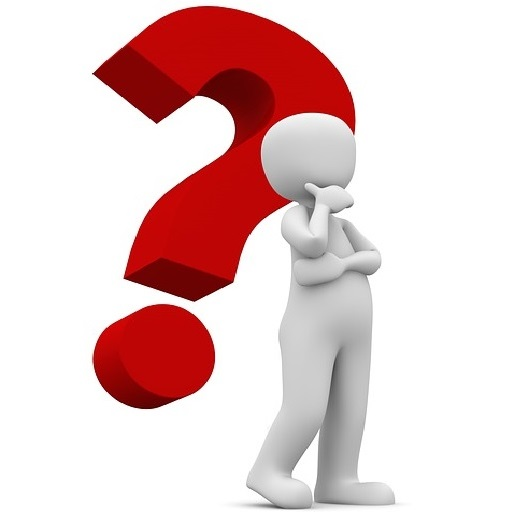
</div>

**Domanda 1**

Che dimensioni hanno le matrici $W_{ih}$, $W_{hh}$ e i vettori $b_{ih}$, $b_{hh}$?

<div>
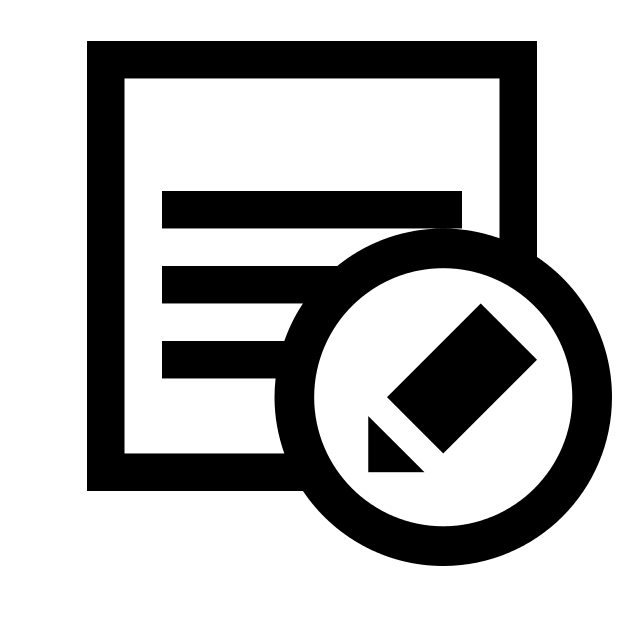
</div>

**Risposta 1**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

La computazione espressa dalla formula sopra può essere riassunta dalla seguente figura:

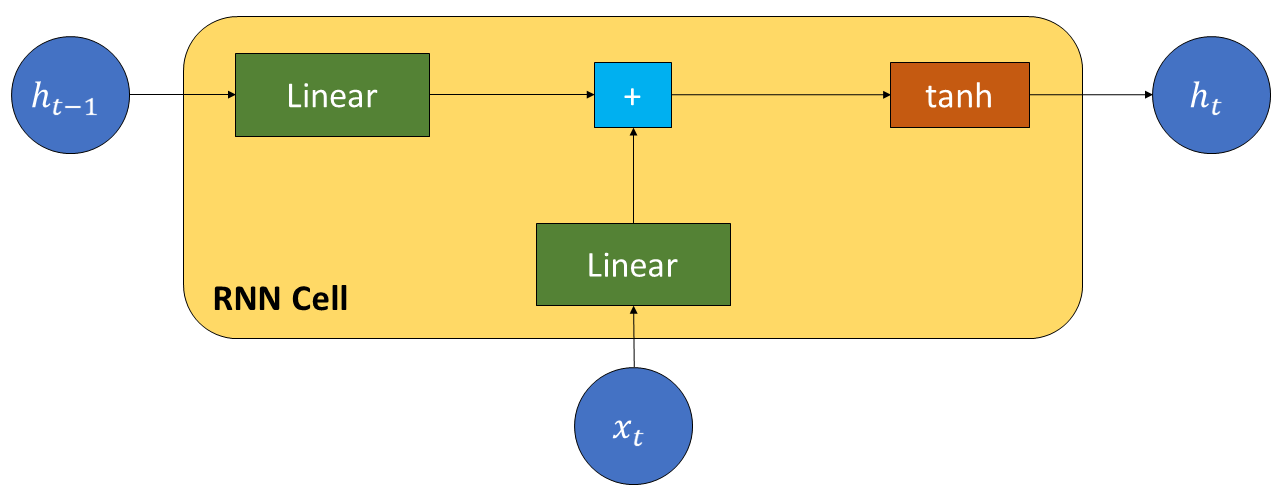

Come possiamo notare l'input della cella RNN è una coppia di valori $h_{t-1}$ (hidden cell) e $x_t$ (input). Possiamo usare una RNN per analizzare una sequenza di input $\{x_t\}_t$ applicando la cella in maniera ricorsiva come segue:

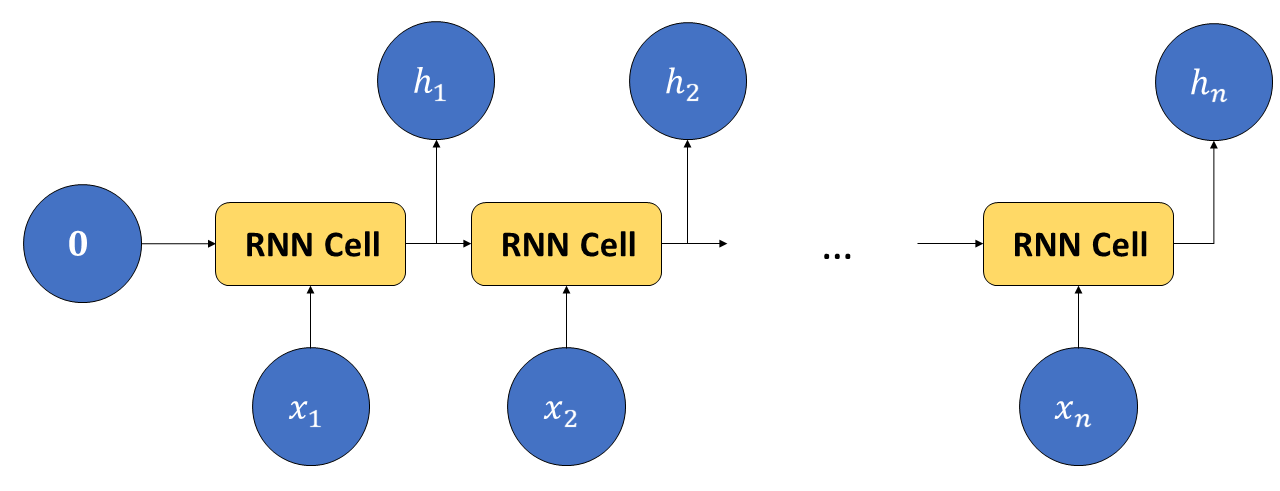

Da notare che $h_0$ viene inizializzata con degli zeri (caso base della ricorsione). In questo caso l'input è una sequenza di vettori $\{x_t\}_t$, mentre l'output è una sequenza di vettori $\{h_t\}_t$.

## 1.2 RNN per la classificazione di cognomi

Vedremo un semplice esempio di utilizzo di un RNN per classificare sequenze. Riprenderemo l'esempio proposto dai tutorial di PyTorch (https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) sulla classificazione di cognomi.

Il problema considerato consiste nell'analizzare un cognome (inteso come una sequenza di caratteri) e classificarne la lingua di appartenenza. Ad esempio "Rossi" dovrebbe essere riconosciuto come un cognome italiano, mentre "Smith" come un cognome inglese. Va notato che per risolvere questo problema, è necessario avere un modello che modelli la sequenza dei caratteri in input e non solo i singoli caratteri in maniera indipendente come visto nei modelli finora analizzati.

Iniziamo scaricando i dati disponibili a questo link: https://download.pytorch.org/tutorial/data.zip. Estraiamo quindi il contenuto dell'archivio nella directory di lavoro. Nella cartella `data/names` sono contenuti dei file di testo nel formato `[lingua].txt`. 

Carichiamo tutti i file, trasformiamo i nomi da unicode a ascii e mettiamo nomi e relative etichette in due liste:

In [2]:
import glob
import unicodedata
import string

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in string.ascii_letters
    )


names = []
labels = []
classes = []

language_files = sorted(glob.glob('data/names/*.txt'))
for f in language_files:
    #otteniamo la lingua dal nome del file
    language = f.split('/')[-1].split('.')[0]
    classes.append(language)
    with open(f, 'r') as ff:
        nn = list(map(unicodeToAscii, ff.readlines()))
    names.extend(nn)
    labels.extend([language]*len(nn))

Controlliamo quanti elementi abbiamo:

In [3]:
len(names), len(labels)

(20074, 20074)

Visualizziamo i primi elementi e le loro etichette:

In [4]:
names[:3], labels[:3]

(['Khoury', 'Nahas', 'Daher'], ['Arabic', 'Arabic', 'Arabic'])

Controlliamo infine il numero di classi:

In [5]:
len(classes)

18

Il nostro modello dovrà analizzare le sequenze di caratteri, pertanto abbiamo bisogno di trasfromare ciascun carattere in un tensore. Dato che abbiamo un numero finito di caratteri, un approccio possibile consiste nel rappresentare ciascun carattere come un one-hot-vector. Ad esempio, il carattere "a" può essere rappresentato mediante il vettore `[1, 0, 0, ...., 0]` se a è il primo primo carattere dell'alfabeto.

Definiamo il nostro alfabeto considerando tutte le lettere ascii e alcuni segni di punteggiatura:

In [6]:
alphabet = string.ascii_letters + " .,;'"
print(len(alphabet), alphabet)

57 abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


Il nostro alfabeto contiene `57` elementi. Possiamo trovare l'indice di un dato carattere mediante il metodo `find` delle stringhe:

In [7]:
alphabet.find('a')

0

Scriviamo dunque un codice che trasformi ciascun nome in una sequenza di one hot vector:

In [8]:
import torch
def name_to_tensor(name):
    tensor = torch.zeros(len(name), len(alphabet))
    sequence_idx = range(len(name)) #0, 1, 2, 3, ...
    char_id = [alphabet.find(c) for c in name]
    tensor[sequence_idx, char_id] =1   
    return tensor

Proviamo il codice scritto sopra:

In [9]:
ciao_tensor = name_to_tensor('ciao')

Visualizziamo il one hot vector del carattere 'a' (il terzo):

In [10]:
ciao_tensor[2]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])

Assegniamo inoltre ad ogni classe un id numerico:

In [11]:
class_to_id = {c:i for i,c in enumerate(classes)}
id_to_class = {x:y for y,x in class_to_id.items()}
class_to_id['Italian'], id_to_class[9]

(9, 'Italian')

A questo punto trasfromiamo la lista di nomi in una lista di tensori e la lista di classi in una lista di id:

In [12]:
names_tensors = [name_to_tensor(x) for x in names]
labels_id = [class_to_id[x] for x in labels]

Mettiamo insieme quanto visto finora per costruire un oggetto di tipo dataset. Suddivideremo inoltre in training e test set in maniera casuale usando un seed:

In [13]:
from torch.utils.data import Dataset
import numpy as np

class NamesDataset(Dataset):
    def __init__(self, path_to_dir='data', training = True, seed=42, test_size=0.7):
        self.alphabet = string.ascii_letters + " .,;'"
        # Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
        def unicodeToAscii(s):
            return ''.join(
                c for c in unicodedata.normalize('NFD', s)
                if unicodedata.category(c) != 'Mn'
                and c in self.alphabet
            )

        names = []
        labels = []
        classes = []

        language_files = sorted(glob.glob(path_to_dir+'/names/*.txt'))
        for f in language_files:
            #otteniamo la lingua dal nome del file
            language = f.split('/')[-1].split('.')[0]
            classes.append(language)
            with open(f, 'r') as ff:
                nn = list(map(unicodeToAscii, ff.readlines()))
            names.extend(nn)
            labels.extend([language]*len(nn))
            
        #effettuiamo lo split random
        np.random.seed(seed)
        idx = np.random.permutation(len(names))
        idx_train = idx[:int(len(idx)*test_size)]
        idx_test = idx[int(len(idx)*test_size):]
        
        if training:
            names = np.array(names)[idx_train]
            labels = np.array(labels)[idx_train]
        else:
            names = np.array(names)[idx_test]
            labels = np.array(labels)[idx_test]
            
        
        self.class_to_id = {c:i for i,c in enumerate(classes)}
        self.id_to_class = {x:y for y,x in self.class_to_id.items()}
        
        self.names_tensors = [self.name_to_tensor(x) for x in names]
        self.labels_id = [self.class_to_id[x] for x in labels]
        
        
    def name_to_tensor(self, name):
        tensor = torch.zeros(len(name), len(self.alphabet))
        sequence_idx = range(len(name)) #0, 1, 2, 3, ...
        char_id = [self.alphabet.find(c) for c in name]
        tensor[sequence_idx, char_id] =1   
        return tensor

    def __len__(self):
        return len(self.names_tensors)

    def __getitem__(self, idx):
        return self.names_tensors[idx], self.labels_id[idx]

Verifichiamo che tutto funzioni correttamente:

In [14]:
training_set = NamesDataset(training=True)
print(len(training_set))
print(training_set[0][0].shape, training_set[0][1])
print(training_set[925][0].shape, training_set[926][1])

14051
torch.Size([5, 57]) 10
torch.Size([8, 57]) 12


L'oggetto dataset ci permette di caricare i nomi come sequenze di un numero variabile di vettori di dimensione $57$. Ogni vettore è associato a una etichetta. Controlliamo che lo stesso valga per il dataset di test:

In [15]:
test_set = NamesDataset(training=False)
print(len(training_set))
print(test_set[0][0].shape, test_set[0][1])
print(test_set[925][0].shape, test_set[926][1])

14051
torch.Size([3, 57]) 11
torch.Size([4, 57]) 14


Costruiamo adesso dei DataLoader. Dato che ogni sequenza del dataset ha una lunghezza diversa, ultizzeremo intanto un batch size uguale a $1$.

In [16]:
from torch.utils.data import DataLoader
train_loader = DataLoader(training_set, shuffle=True, batch_size=1)
test_loader = DataLoader(test_set, shuffle=False, batch_size=1)

<div>
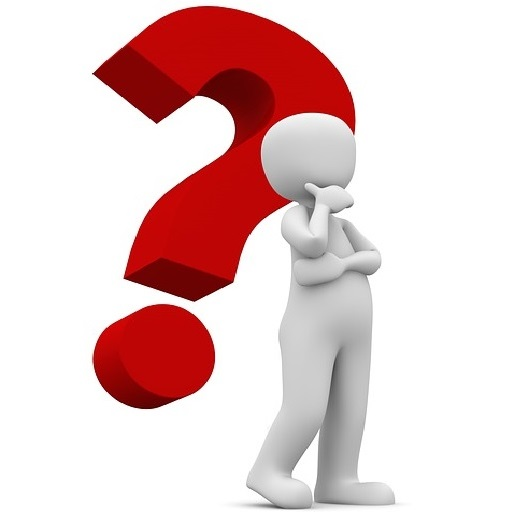
</div>

**Domanda 2**

Perché non è possibile utilizzare un batch size diverso da 1?

<div>
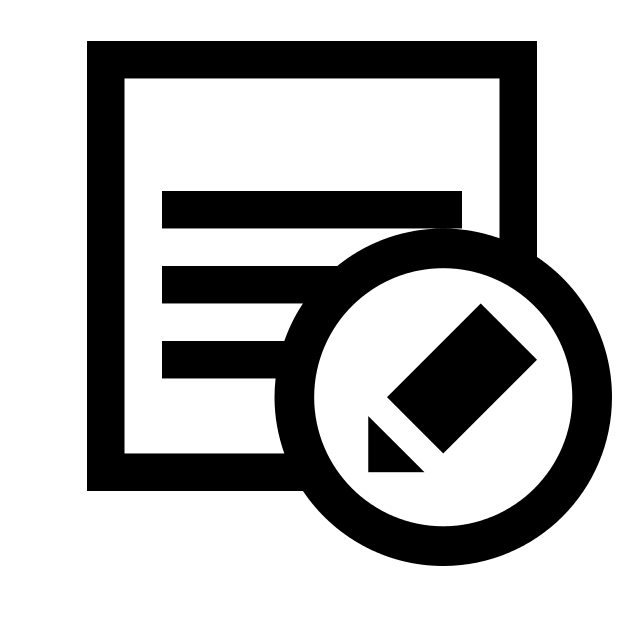
</div>

**Risposta 2**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Costruiamo adesso una architettura basata su RNN che ci permetta di classificare ciascuna sequenza. L'input di questo modello sarà un sequenza, mentre l'output è una etichetta. Dato che ci interessa ottenere un solo valore in output, considereremo solamente l'ultimo valore generato dalla RNN $h_t$. Dato che abbiamo $18$ classi, il nostro output dovrebbe contenere $18$ elementi. Per evitare di imporre che la dimensione del layer nascosto sia pari al numero di classi, introduciamo un layer di tipo `Linear` per trasformare l'ultimo hidden layer nell'output desiderato. Ciò permetterà inoltre di mappare il range dell'hidden layer ($[-1,1]$) su un range arbitrario. Il modello seguirà la seguente architettura:

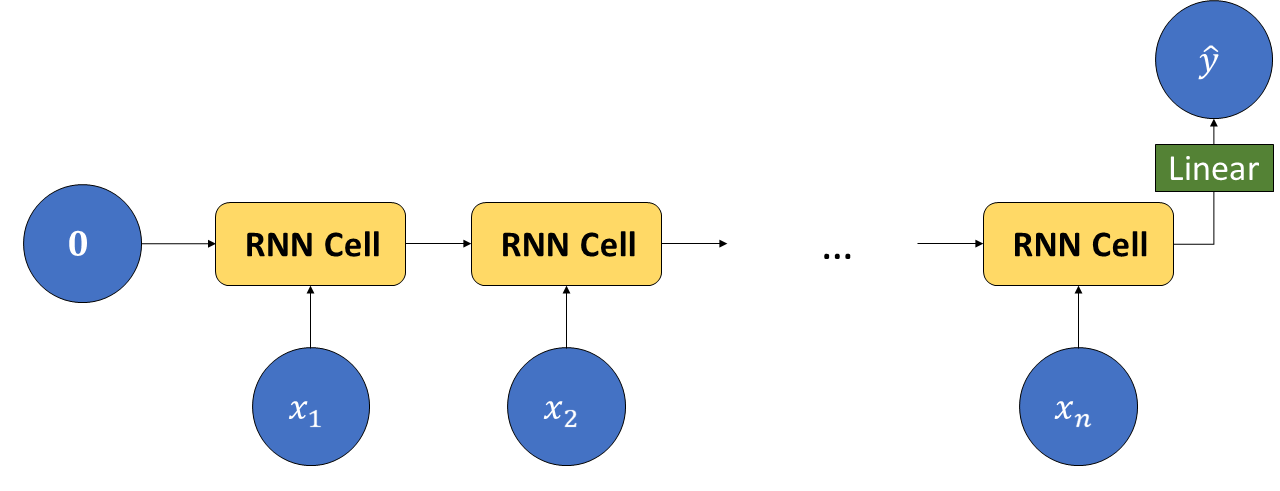

<div>
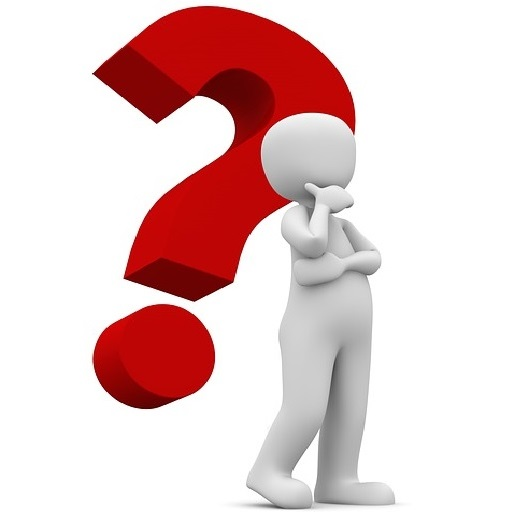
</div>

**Domanda 3**

Perché il range dell'hidden layer è $[-1,1]$? In quali casi serve avere un range diverso?

<div>
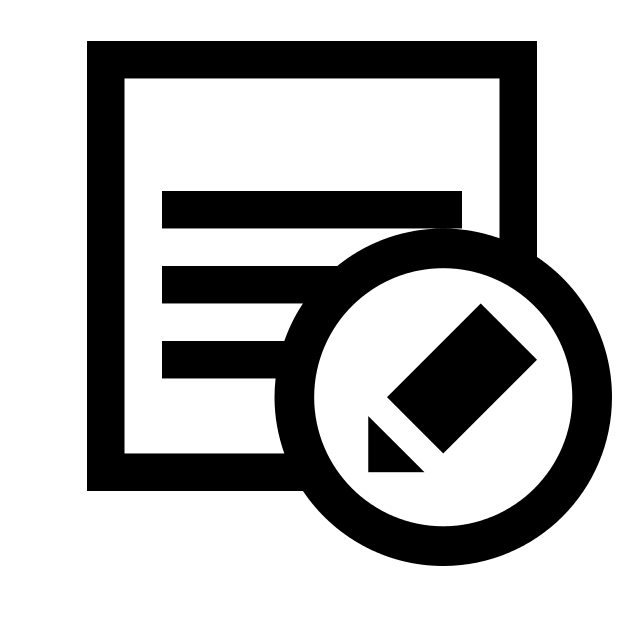
</div>

**Risposta 3**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Definiamo l'architettura facendo uso della implementazione delle RNN fornita da PyTorch:

In [17]:
from torch import nn
class NameClassifier(nn.Module):
    def __init__(self, input_size =57, hidden_size=128, output_size=18):
        super(NameClassifier, self).__init__()
        #In PyTorch le RNN supportando due formati di input:
        # batch_size x seq_len x dim
        # seq_len x batch_size x dim
        #noi specifichiamo batch_first=True per utilizzare il primo formato
        self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        

    def forward(self, x):
        # il secondo output contiene il valore dell'ultimo hiddel layer
        # il primo output contiene tutti gli altri valori
        # scartiamo il primo output perché non ci interessano tutti gli output
        _, ht = self.rnn(x)
        
        # ht è nel formato 1 x batch_size, dove "1" indica che la rete ha un solo layer
        # chiamiamo squeeze(0) per rimuovere questo "1"
        
        ht = ht.squeeze(0)
        
        #applichiamo il layer Linear:
        y = self.linear(ht)
        return y

Definiamo adesso il modulo di Lightning per effettuare il training:

In [18]:
import pytorch_lightning as pl
import itertools
from torch.utils.data import DataLoader
import torchvision
from torch.optim import SGD
from sklearn.metrics import accuracy_score

class ClassificationRNN(pl.LightningModule):
    def __init__(self, 
                 model,
                 lr=0.01, 
                 momentum=0.99):
        super(ClassificationRNN, self).__init__()
        self.save_hyperparameters()
        
        self.model = model
        self.criterion = nn.CrossEntropyLoss() 
                    
    def forward(self, x):
        return self.model(x)
        
    def configure_optimizers(self):
        return SGD(self.model.parameters(), self.hparams.lr, momentum=self.hparams.momentum)    
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        l = self.criterion(output,y)
        
        self.log('train/loss', l)
        
        return l
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        predictions = output.cpu().topk(1).indices
        
        return {
            'predictions': output.cpu().topk(1).indices,
            'labels': y.cpu()
        }
    
    def validation_epoch_end(self, outputs):
        predictions = np.concatenate([o['predictions'] for o in outputs])
        labels = np.concatenate([o['labels'] for o in outputs])
        
        acc = accuracy_score(labels, predictions)
        
        self.log('val/accuracy', acc)

Effettuiamo il training. Facciamo training solo per poche epoche in quanto questo modello è poco ottimizzato (vediamo fra poco perché).

In [19]:
from pytorch_lightning.loggers import TensorBoardLogger

names_rnn = ClassificationRNN(NameClassifier())

logger = TensorBoardLogger("rnn_logs", name="names_rnn")

names_rnn_trainer = pl.Trainer(max_epochs=2, gpus=1, logger=logger)
names_rnn_trainer.fit(names_rnn, train_loader, test_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | NameClassifier   | 26.3 K
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
26.3 K    Trainable params
0         Non-trainable params
26.3 K    Total params
0.105     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/furnari/miniconda3/envs/dl/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/home/furnari/miniconda3/envs/dl/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Alla fine del training, possiamo validare i risultati come segue:

In [20]:
names_rnn_trainer.validate(names_rnn, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/furnari/miniconda3/envs/dl/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val/accuracy': 0.034534286707639694}
--------------------------------------------------------------------------------


[{'val/accuracy': 0.034534286707639694}]

## 1.3 Padding delle sequenze

Finora abbiamo effettuato il training con batch size pari a 1, il che ha limitato molto la velocità della rete. Se proviamo a cambiare il batch size, otteniamo un errore. Ciò è dovuto al fatto che ciascuna sequenza ha una lunghezza diversa e quindi non è possibile concatenare i tensori relative alle singole sequenze in un unico tensore. Ad esempio, due sequenze di shape `[8, 57]` e `[3, 57]` non possono essere concatenate in un unico tensore di shape `[?, 57]`. Per ovviare a questo problema, è possibile formare un batch aggiungendo degli zeri al tensore più piccolo in modo che le due dimensioni coincidano. I due tensori possono essere quindi concatenati in un unico tensore di shape `[2, 8, 57]`. Questa operazione è detta "padding" e può essere implementata come segue in PyTorch:

In [21]:
from torch.nn.utils.rnn import pad_sequence

def collate(elements):
    labels = torch.Tensor([e[1] for e in elements]).long()
    sequences = [e[0] for e in elements]
    batch = pad_sequence(sequences, batch_first = True)
    
    return batch, labels

train_loader = DataLoader(training_set, shuffle=True, batch_size=16, collate_fn=collate)
test_loader = DataLoader(test_set, batch_size=16, collate_fn=collate)

In particolare abbiamo ridefinito la funzione `collate_fn` che viene richiamata dal DataLoader quando è necessario raggruppare una serie di elementi in un batch. Proviamo a visualizzare le shape di qualche batch:

In [22]:
for batch in train_loader:
    print(batch[0].shape)
    break
for batch in train_loader:
    print(batch[0].shape)
    break

torch.Size([16, 11, 57])
torch.Size([16, 10, 57])


<div>
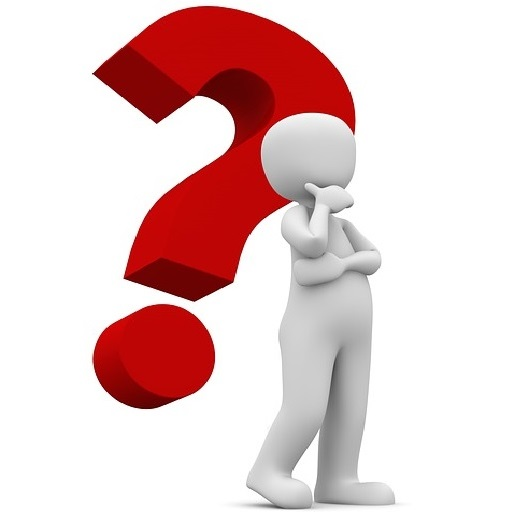
</div>

**Domanda 4**

I batch generati dal dataloader hanno in genere dimensioni diverse. Questo è un problema durante il training? Perché?

<div>
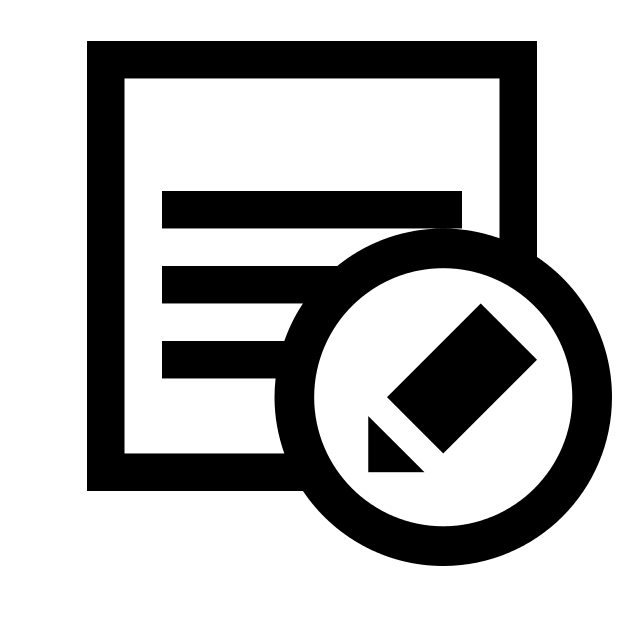
</div>

**Risposta 4**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Effettuiamo il training:

In [23]:
from pytorch_lightning.loggers import TensorBoardLogger

names_rnn = ClassificationRNN(NameClassifier())

logger = TensorBoardLogger("rnn_logs", name="names_rnn")

names_rnn_trainer = pl.Trainer(max_epochs=150, gpus=1, logger=logger,progress_bar_refresh_rate=0)
names_rnn_trainer.fit(names_rnn, train_loader, test_loader)

/home/furnari/miniconda3/envs/dl/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | NameClassifier   | 26.3 K
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
26.3 K    Trainable params
0         No

Alla fine del training, dovremmo ottenere un grafico del genere:

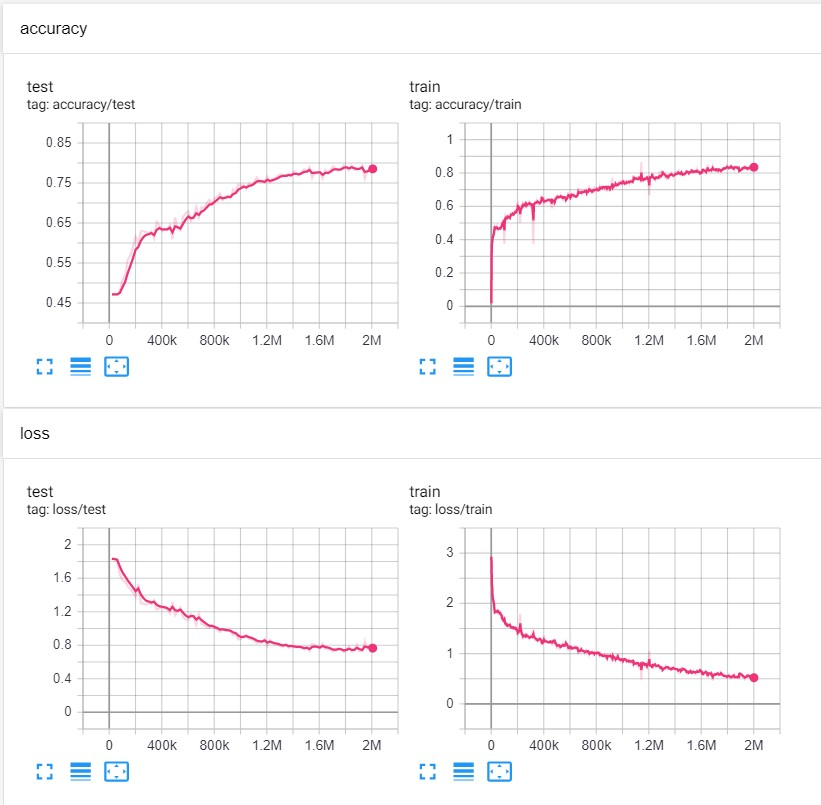

Validiamo anche in questo caso:

In [24]:
names_rnn_trainer.validate(names_rnn, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/furnari/miniconda3/envs/dl/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val/accuracy': 0.18346339464187622}
--------------------------------------------------------------------------------


[{'val/accuracy': 0.18346339464187622}]

<div>
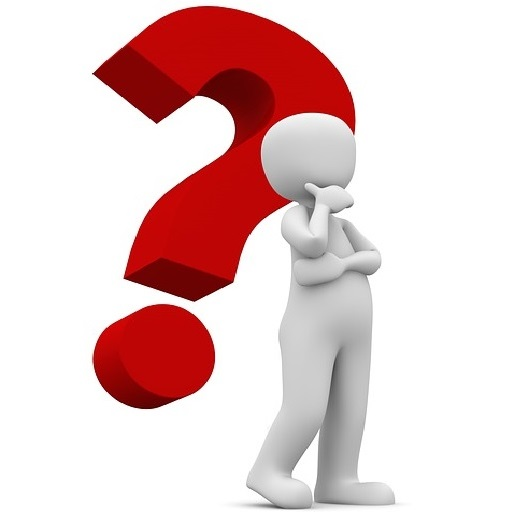
</div>

**Domanda 5**

Il padding delle sequenze cambia il modo in cui viene effettuato il training? In fase di test è strettamente necessario effettuare il padding?

<div>
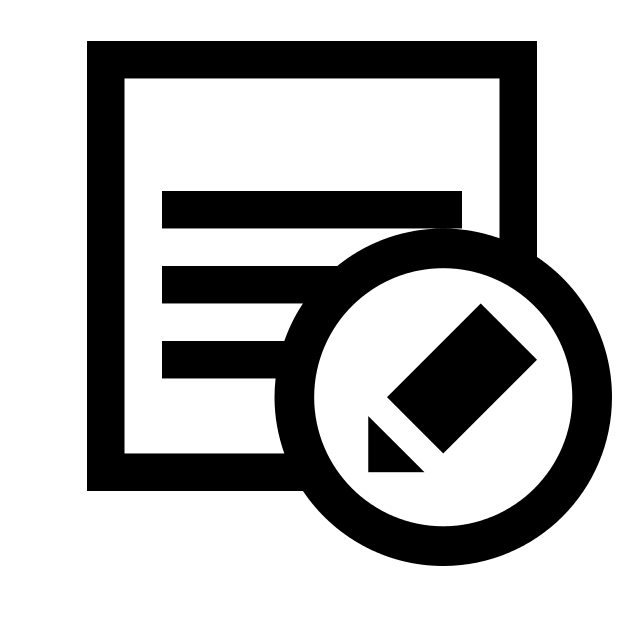
</div>

**Risposta 5**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

## 1.4 LSTM

PyTorch mette a disposizione diversi modelli di RNN, tra cui LSTM e GRU. Utilizzare questi modelli è molto semplice. A differenza di una semplice RNN, una LSTM include un input gate, che modula il contributo della lettura dell'input, un forget gate, che regola quanto dello stato che viene dallo scorso timestep vada "dimenticato" e un output gate, che permette di generare l'output della cella. In maniera simile a una RNN classica, ad ogni timestep una LSTM prende in input un valore ed emette un hidden vector. Oltre all'hidden vector, la LSTM produrrà anche un altro vettore detto "cell state". Le seguenti equazioni descrivono il funzionamento di una LSTM:

$$ f_t = \sigma(W_f[h_{t-1}, x_t]+b_f)\ \text{(forget gate)}$$
$$ i_t = \sigma(W_i[h_{t-1}, x_t]+b_i)\ \text{(input gate)}$$
$$ \tilde{C}_t = \tanh(W_C[h_{t-1}, x_t]+b_C)\ \text{(candate cell state)}$$
$$C_t = f_t C_{t-1} + i_t \tilde{C}_{t}\ \text{(cell state)}$$
$$ o_t = \sigma(W_o[h_{t-1}, x_t]+b_o)\ \text{(output gate)}$$
$$h_t = o_t \tanh(C_t)\ \text{(hidden vector)}$$

Il funzionamento di una LSTM è riassunto dal seguente schema:

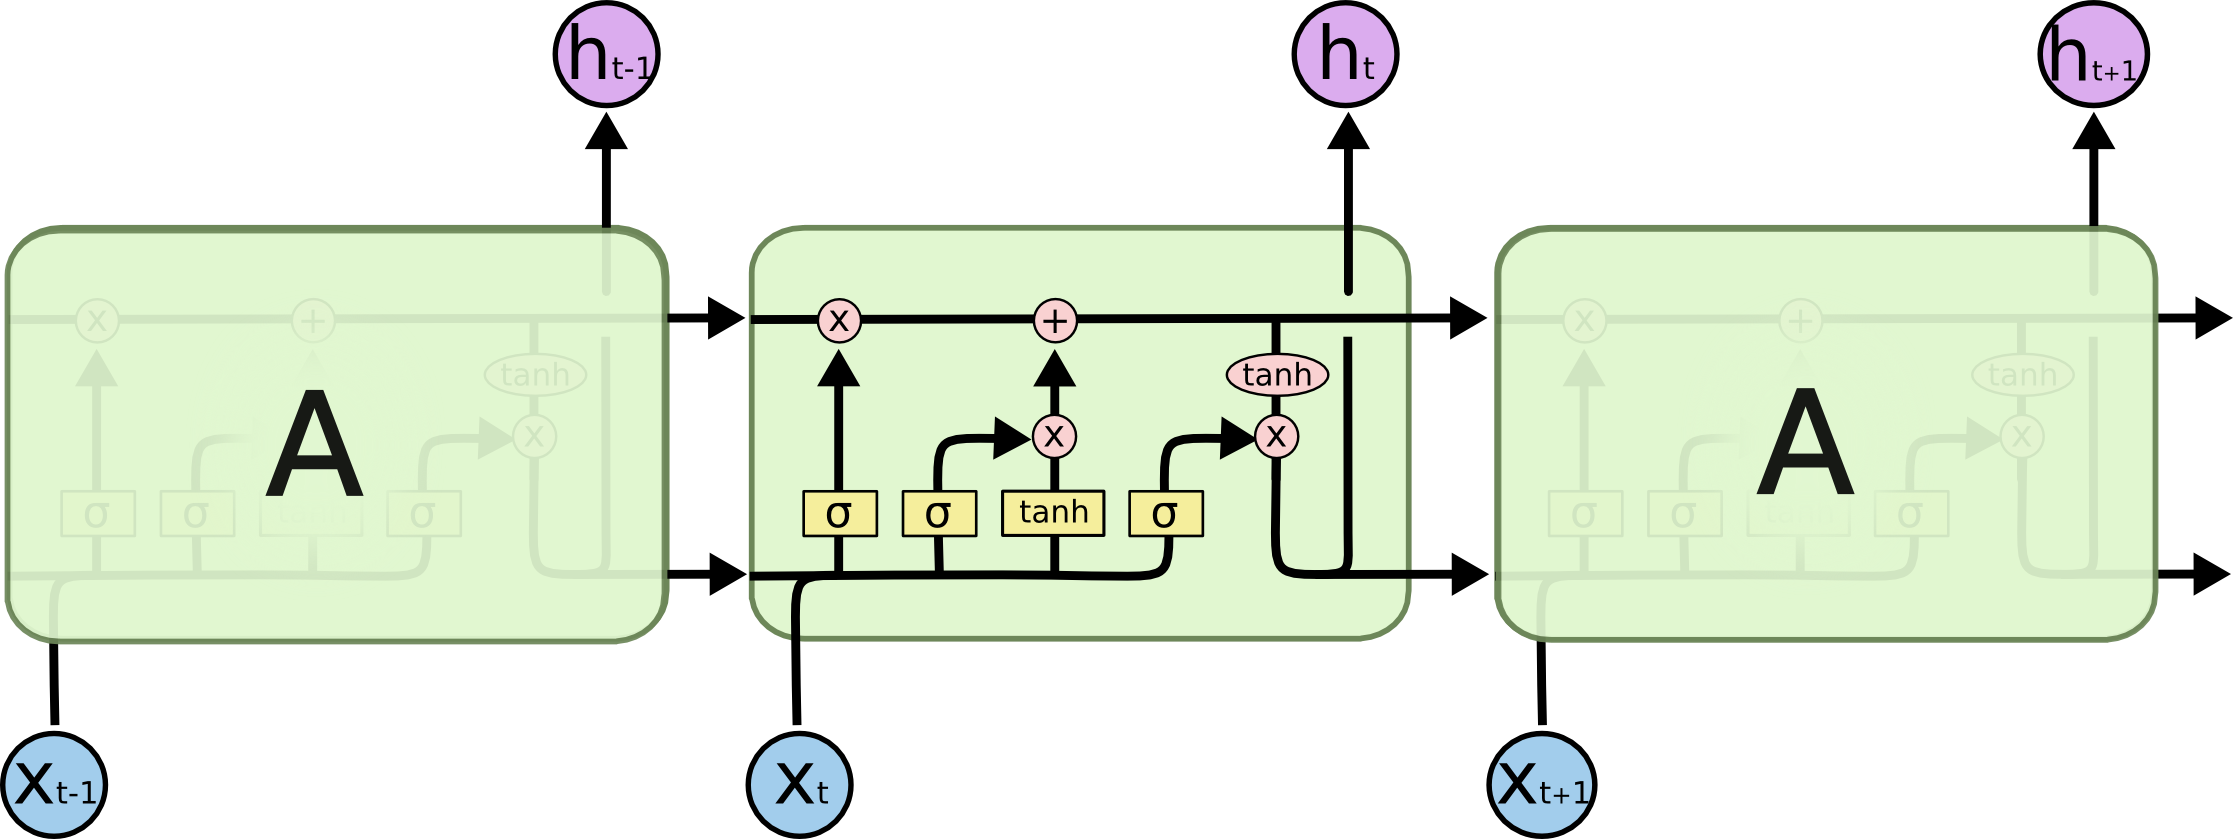

Per una descrizione più approfondita, vedere qui: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

Le LSTM sono implementate dal modulo `torch.nn.LSTM`. Vediamo un esempio:

In [25]:
from torch.nn import LSTM
# input di dimensione 10
# hidden state di dimensione 128
model = LSTM(10, 128, batch_first=True)

# una sequenza di 100 feature di dimensione 10
batch = torch.zeros(1, 100, 10)

# la LSTM restituisce tutti gli hidden state per i vari timestep t
# l'ultimo hidden state
# l'ultimo cell state
all_hidden, (h_n, c_n) = model(batch)
print(all_hidden.shape)
print(h_n.shape)
print(c_n.shape)
print((all_hidden[:,-1,:]==h_n).all())

torch.Size([1, 100, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
tensor(True)


Per effettuare la classificazione dei nomi, ci servirà dunque solo `h_n`. Riscriviamo il modulo di classificazione usando una LSTM invece di una classica RNN:

In [26]:
from torch import nn
class NameClassifierLSTM(nn.Module):
    def __init__(self, input_size =57, hidden_size=128, output_size=18):
        super(NameClassifierLSTM, self).__init__()
        # usiamo LSTM invece di RNN
        self.rnn = nn.LSTM(input_size = input_size, hidden_size = hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        

    def forward(self, x):
        # Scartiamo la lista degli output e l'ultimo cell state
        _, (ht, _) = self.rnn(x)
        
        ht = ht.squeeze(0)
        
        #applichiamo il layer Linear:
        y = self.linear(ht)
        return y

Possiamo dunque allenare il modello come segue:

In [27]:
names_lstm = ClassificationRNN(NameClassifierLSTM())

logger = TensorBoardLogger("rnn_logs", name="names_lstm")
names_lstm_trainer = pl.Trainer(max_epochs=150, gpus=1, logger=logger,progress_bar_refresh_rate=0)
names_lstm_trainer.fit(names_lstm, train_loader, test_loader)

/home/furnari/miniconda3/envs/dl/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | NameClassifierLSTM | 98.1 K
1 | criterion | CrossEntropyLoss   | 0     
-------------------------------------------------
98.1 K    Trainable params
0 

Validiamo anche in questo caso:

In [28]:
names_lstm_trainer.validate(names_lstm, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/furnari/miniconda3/envs/dl/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val/accuracy': 0.8120537996292114}
--------------------------------------------------------------------------------


[{'val/accuracy': 0.8120537996292114}]

<div>
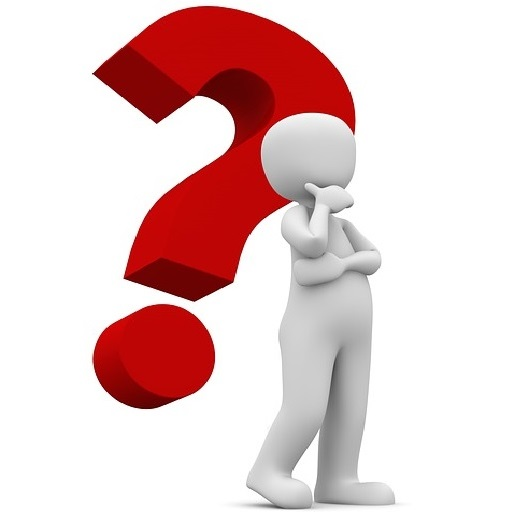
</div>

**Domanda 6**

Si confrontino i risultati ottenuti con la LSTM con quelli ottenuti con la RNN. Ci sono delle differenze?

<div>
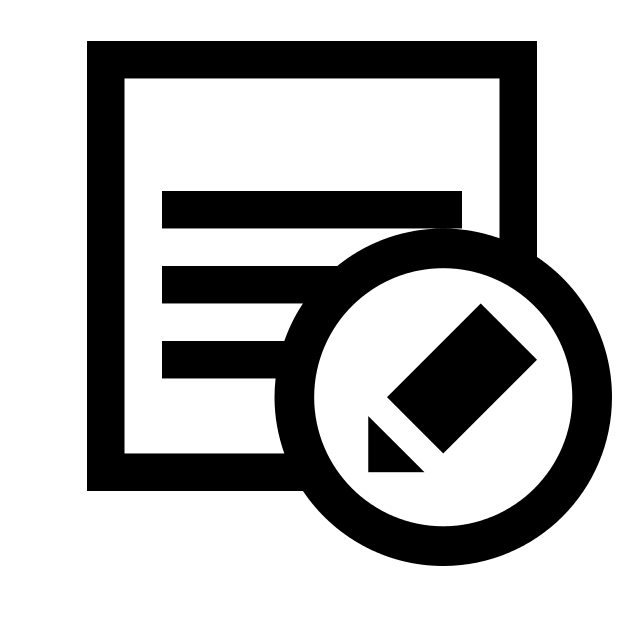
</div>

**Risposta 6**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

# 2 Generazione di nomi (one to many)

Vediamo adesso un esempio di utilizzo di una RNN per un tipo di mapping one-to-many. In particolare, vedremo come allenare una rete ricorrente a generare nomi a partire dalla lettera iniziale. Il mapping one-to-many è dunque il mapping tra la prima lettera in input e la sequenza di lettere in uscita.  Per generare caratteri, seguiremo questo schema:

 * La RNN prende in input il primo carattere della sequenza all prima iterazione il carattere precedente in tutte le altre iterazioni;
 * La RNN può emettere un carattere di terminazione che indica che ha finito di generare caratteri. Quando questo carattere viene emesso, la generazione viene arrestata;
 * Rappresenteremo i caratteri predetti mediante un problema di classificazione in cui prediciamo gli score dei singoli caratteri.
 
La predizione seguirà il seguente approccio (da https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html):

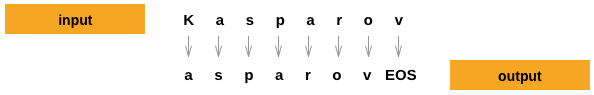

Dove `EOS` sta per "end of sequence" e segnala che la sequenza è terminata. Iniziamo ri-definendo il modulo dataset partendo da quello definito in precedenza. Vogliamo che il dataset restituisca:

 * La sequenza di caratteri in input;
 * La sequenza di caratteri desiderata in output;
 * La classe del nome (nazionalità).
 
Passeremo la classe come input al modello, quindi invece di restituire degli indici, restituiremo dei one-hot vector come nel caso dei caratteri.
 
Implementiamo il modulo:

In [29]:
class NamesPredictionDataset(Dataset):
    def __init__(self, path_to_dir='data', training = True, seed=42, test_size=0.7):
        self.alphabet = string.ascii_letters + " .,;'"
        # Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
        def unicodeToAscii(s):
            return ''.join(
                c for c in unicodedata.normalize('NFD', s)
                if unicodedata.category(c) != 'Mn'
                and c in self.alphabet
            )

        names = []
        labels = []
        classes = []

        language_files = sorted(glob.glob(path_to_dir+'/names/*.txt'))
        for f in language_files:
            #otteniamo la lingua dal nome del file
            language = f.split('/')[-1].split('.')[0]
            classes.append(language)
            with open(f, 'r') as ff:
                nn = list(map(unicodeToAscii, ff.readlines()))
            names.extend(nn)
            labels.extend([language]*len(nn))
            
        #effettuiamo lo split random
        np.random.seed(seed)
        idx = np.random.permutation(len(names))
        idx_train = idx[:int(len(idx)*test_size)]
        idx_test = idx[int(len(idx)*test_size):]
        
        if training:
            names = np.array(names)[idx_train]
            labels = np.array(labels)[idx_train]
        else:
            names = np.array(names)[idx_test]
            labels = np.array(labels)[idx_test]
            
        
        self.class_to_id = {c:i for i,c in enumerate(classes)}
        self.id_to_class = {x:y for y,x in self.class_to_id.items()}
        
        self.input_tensors = [self.name_to_tensor(x) for x in names]
        self.output_sequences = [self.input_to_output(x) for x in names]
        self.category_tensors = [self.one_hot_category(len(self.id_to_class),self.class_to_id[x]) for x in labels]
        
    def one_hot_category(self, num_categories, category):
        tensor = torch.zeros(num_categories)
        tensor[category]=1
        return tensor
        
    def name_to_tensor(self, name):
        #inserisco "len(self.alphabet)+1" per includere una classe per il carattere EOS
        tensor = torch.zeros(len(name), len(self.alphabet)+1)
        sequence_idx = range(len(name)) #0, 1, 2, 3, ...
        char_id = [self.alphabet.find(c) for c in name]
        tensor[sequence_idx, char_id] =1   
        return tensor
    
    def input_to_output(self, name):
        name = name[1:] #scarta il primo carattere
        # aggiungi il carattere EOS (ultimo ID)
        sequence = [self.alphabet.find(c) for c in name] + [len(self.alphabet)]
        return sequence

    def __len__(self):
        return len(self.input_tensors)

    def __getitem__(self, idx):
        input_tensor = self.input_tensors[idx]
        output_sequence = torch.Tensor(self.output_sequences[idx]).long()
        category_tensor = self.category_tensors[idx]
        return input_tensor, output_sequence, category_tensor

Vediamo un esempio:

In [30]:
train_set = NamesPredictionDataset()
input_tensor, output_tensor, category_tensor = train_set[0]
print(input_tensor.shape)
print(output_tensor.shape)
print(category_tensor.shape)

torch.Size([5, 58])
torch.Size([5])
torch.Size([18])


Vediamo adesso gli indici dei one-hot vectors contenuti nei due tensori:

In [31]:
input_tensor.argmax(-1), output_tensor, category_tensor.argmax()

(tensor([38,  0,  8, 19,  0]), tensor([ 0,  8, 19,  0, 57]), tensor(10))

Definiamo la funzione `collate` con il padding delle sequenze e i loader di train e test:

In [32]:
from torch.nn.utils.rnn import pad_sequence

def collate(elements):
    input_sequences = [e[0] for e in elements]
    output_sequences = [e[1] for e in elements]
    categories = torch.stack([e[2] for e in elements])
    
    input_sequences = pad_sequence(input_sequences, batch_first = True)
    # nel caso delle etichette, facciamo padding con -100, che un valore che verrà ignorato dalla cross entropy
    output_sequences = pad_sequence(output_sequences, batch_first = True, padding_value=-100)
    
    return input_sequences, output_sequences, categories

test_set = NamesPredictionDataset(training=False)

train_loader = DataLoader(train_set, shuffle=True, batch_size=16, collate_fn=collate, num_workers=2)
test_loader = DataLoader(test_set, batch_size=16, collate_fn=collate, num_workers=2)

<div>
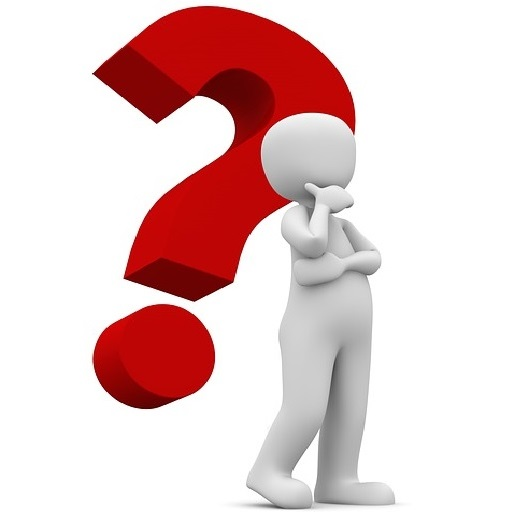
</div>

**Domanda 7**

Si notano delle similarità tra i due vettori? Quali? Qual è l'ultimo indice contenuto nel tensore di output? A cosa corrisponde?

<div>
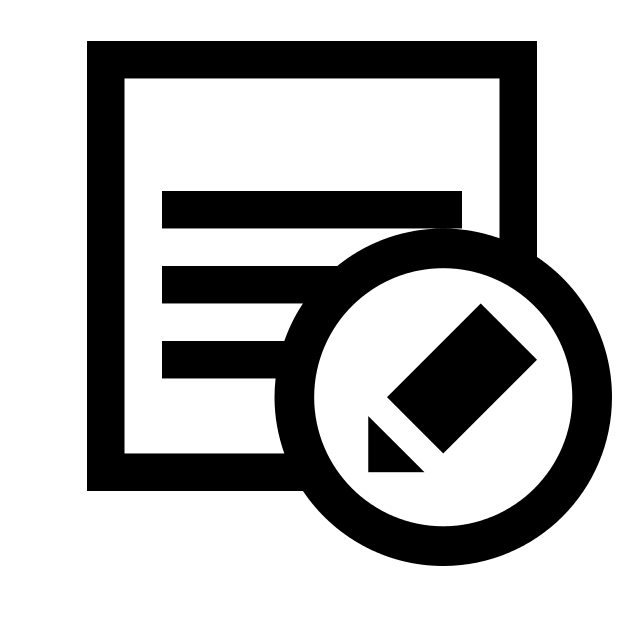
</div>

**Risposta 7**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Adesso definiamo una rete neurale basato su LSTM che ci permetta di generare le sequenze. La rete dovrà prendere in input la sequenza di input e la categoria e restituire una sequenza di caratteri di output. Durante il training, imporremo che la sequenza predetta sia uguale a quella di ground truth. Inseriremo inoltre un metodo `sample` che ci permetta di generare un nuovo nome a partire da un carattere iniziale e una categoria.

In [33]:
class GeneratorLSTM(nn.Module):
    def __init__(self,
                 alphabet,
                 categories,
                 hidden_size=128):
        super(GeneratorLSTM, self).__init__()
        
        input_size = len(alphabet)+1 #il +1 serve a considerare anche EOS
        num_categories = len(categories)
        
        self.alphabet = alphabet
        self.categories = categories
        self.hidden_size = hidden_size
        
        # Linear layer per "combinare" carattere in input con la categoria
        self.combiner = nn.Linear(input_size+num_categories, hidden_size)
        # rete ricorrente
        self.rnn = nn.LSTM(input_size = hidden_size, hidden_size = hidden_size, batch_first=True)
        # layer di output
        self.out = nn.Linear(hidden_size, input_size)

    def forward(self, characters, categories):
        # riceviamo un batch di caratteri e categorie
        # Le dimensioni rispettive saranno:
        # characters: BATCH_SIZE x LENGTH x INPUT_SIZE
        # categories: BATCH_SIZE x NUM_CATEGORIES
        
        BS, NS, IS = characters.shape #BATCH_SIZE, NUM_STEPS, INPUT_SIZE
        _, NC = categories.shape #NUM_CATEGORIES
        
        # replichiamo il vettore di categorie per il numero di step
        expanded_categories = categories.unsqueeze(1).expand((BS,NS,NC)) # BS x NC -> BS x NS x NC
        
        # concateniamo characters e categories
        combined = torch.cat([characters, expanded_categories],-1)
        
        # usiamo il layer lineare per proiettare su hidden size
        combined = self.combiner(combined) #shape: BATCH_SIZE x LENGTH x HIDDEN_SIZE
        
        # prendiamo tutti gli output
        outputs, _ = self.rnn(combined) #shape: BATCH_SIZE x LENGTH x HIDDEN_SIZE
        
        #applichiamo il layer Linear
        predicted = self.out(outputs) #shape: BATCH_SIZE x LENGTH x INPUT_SIZE
        return predicted
    
    def get_character_tensor(self, idx):
        character_tensor = torch.zeros(len(self.alphabet)+1)
        character_tensor[idx]=1
        return character_tensor
    
    def sample(self, 
               initial_character=None, #carattere iniziale del nome
               category=None, #categoria
               max_steps=20): #massimo numero di step nel caso in cui non venga mai predetto EOS
        
        # se category non è stato specificato, scegli una categoria a caso
        if category is None:
            category = np.random.choice(list(self.categories.keys()))
        
        # se il carattere di inizio non è stato specificato, scegline uno a caso
        if initial_character is None:
            initial_character = np.random.choice(list(self.alphabet[26:-5])) #specifico 26:-5 per pescare solo tra le lettere maiuscole
            
        # otteniamo l'ID della categoria
        category_id = self.categories[category]
        # trasformiamolo in un tensore one-hot
        category_tensor = torch.zeros(len(self.categories))
        category_tensor[category_id]=1
        
        # otteniamo il one-hot tensor del carattere iniziale
        character_tensor = self.get_character_tensor(self.alphabet.find(initial_character))
        
        # inizializziamo il nome generate con il primo carattere
        generated_name = initial_character
        
        # hidden vector e cell vector saranno inizializzati a zero all'inizio
        hidden_vector = torch.zeros(1, 1, self.hidden_size)
        cell_vector = torch.zeros(1, 1, self.hidden_size)
        
        # conta quanti step abbiamo fatto
        step = 0
        found_eos = False
        while not found_eos:
            # combiniamo il tensore del carattere e quello della categoria
            combined = torch.cat([character_tensor.view(1,1,-1), category_tensor.view(1,1,-1)],-1)
            combined = self.combiner(combined)
            
            # applico la RNN sul vettore combinato passando l'hidden vector e il cell vector e aggiornandoli
            _, (hidden_vector, cell_vector) = self.rnn(combined, (hidden_vector, cell_vector))
            
            # ottengo il carattere predetto
            predicted_character = self.out(hidden_vector) # 1 x 1 x NC
            predicted_character_id = predicted_character.squeeze().argmax()
            
            # conto uno step
            step+=1
            
            if predicted_character_id==len(self.alphabet) or step>max_steps: #carattere EOS o troppi step
                found_eos=True # serve per uscire dal ciclo
            else:
                # aggiungo il carattere a quelli generati
                generated_name += self.alphabet[predicted_character_id]
                # aggiorno il tensore dell'ultimo carattere generato
                character_tensor = self.get_character_tensor(predicted_character_id)
        
        return category, generated_name

Costruiamo il modello e testiamolo con una sequenza fittizia di $5$ caratteri, verificando che l'output sa coerente:

In [34]:
gen = GeneratorLSTM(
    alphabet = train_set.alphabet,
    categories = train_set.class_to_id
)
gen(torch.zeros(2, 5, 58), torch.zeros(2,18)).shape

torch.Size([2, 5, 58])

<div>
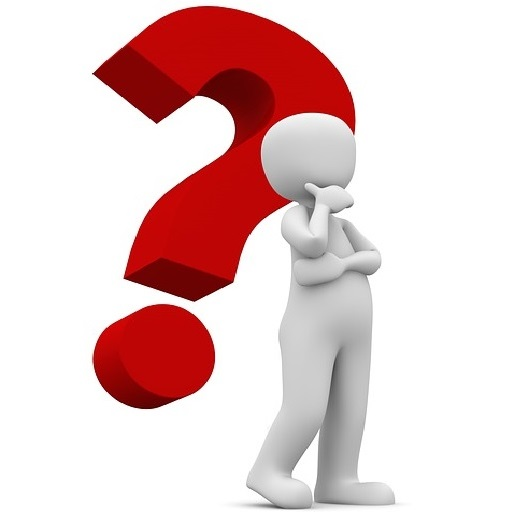
</div>

**Domanda 8**

La shape di output è corretta? Perché?

<div>
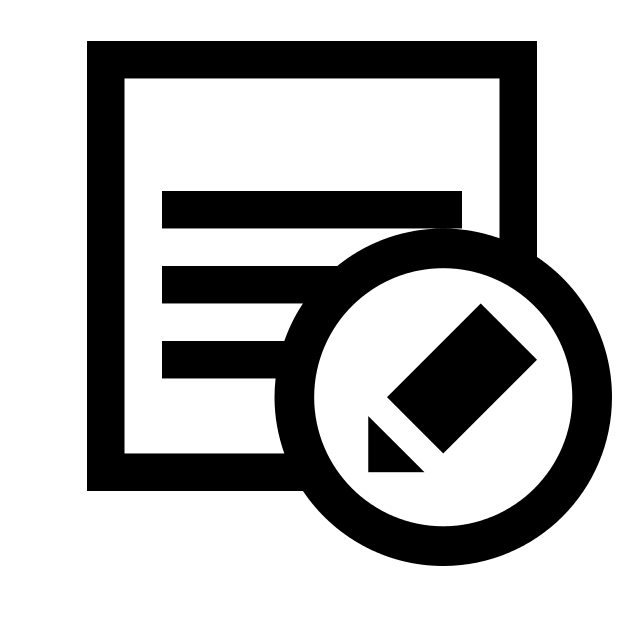
</div>

**Risposta 8**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Proviamo a generare un nome. Il risultato sarà chiaramente poco indicativo dato che il modello non è ancora stato allenato:

In [35]:
gen.sample()

('Czech', 'RNlllllllllllllllllll')

A questo punto definiamo il modulo di PyTorch lightning per il training:

In [36]:
class GenerationRNN(pl.LightningModule):
    def __init__(self, 
                 model,
                 lr=0.01, 
                 momentum=0.99):
        super(GenerationRNN, self).__init__()
        self.save_hyperparameters()
        
        self.model = model
        # utilizzeremo la cross entropy per allenare il modello
        # vedremo il problema della generazione come quello di
        # "classificare" correttamente i caratteri in uscita
        self.criterion = nn.CrossEntropyLoss() 
                    
    def forward(self, x, c):
        # passiamo la sequenza e la cateogira alla forward
        return self.model(x, c)
        
    def configure_optimizers(self):
        return SGD(self.model.parameters(), self.hparams.lr, momentum=self.hparams.momentum)    
    
    def training_step(self, batch, batch_idx):
        input_sequence_tensor, output_characters_ids, category_tensor = batch
        
        predicted_tensor = self(input_sequence_tensor, category_tensor)
        
        loss = self.criterion(
            predicted_tensor.view(-1, predicted_tensor.shape[-1]), #concateniamo gli step sul batch size
            output_characters_ids.view(-1)
        )
        
        acc = (predicted_tensor.view(-1, predicted_tensor.shape[-1]).argmax(-1).view(-1) == output_characters_ids.view(-1)).float().mean()
        
        self.log('train/loss', loss)
        self.log('train/acc', acc)
        return loss
    
    def validation_step(self, batch, batch_idx):
        input_sequence_tensor, output_characters_ids, category_tensor = batch
        
        predicted_tensor = self(input_sequence_tensor, category_tensor)
        
        loss = self.criterion(
            predicted_tensor.view(-1, predicted_tensor.shape[-1]), #concateniamo gli step sul batch size
            output_characters_ids.view(-1)
        )
        
        acc = (predicted_tensor.view(-1, predicted_tensor.shape[-1]).argmax(-1).view(-1) == output_characters_ids.view(-1)).float().mean()
        
        self.log('val/loss', loss)
        self.log('val/acc', acc)
        return loss

In [37]:
generator_lstm = GenerationRNN(
            GeneratorLSTM(
                alphabet = train_set.alphabet,
                categories = train_set.class_to_id
            )
        )

logger = TensorBoardLogger("rnn_logs", name="names_generator_lstm")
generator_lstm_trainer = pl.Trainer(max_epochs=10, gpus=1, logger=logger, progress_bar_refresh_rate=0)
generator_lstm_trainer.fit(generator_lstm, train_loader, test_loader)

/home/furnari/miniconda3/envs/dl/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | GeneratorLSTM    | 149 K 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
149 K     Trainable params
0         No

Proviamo adesso a generare dei nomi:

In [38]:
for i in range(15):
    language, name = generator_lstm.model.cpu().sample()
    print(f"{language:15}: {name}")

Chinese        : Ung
Irish          : Brann
German         : Gerner
Portuguese     : Esander
Greek          : Wakos
Vietnamese     : Fung
Portuguese     : Ros
Spanish        : Inagrandez
Polish         : Panek
Italian        : Joni
Dutch          : Lann
Greek          : Ontopoulos
Russian        : Handyukov
Greek          : Stroumanis
Irish          : Xann


<div>
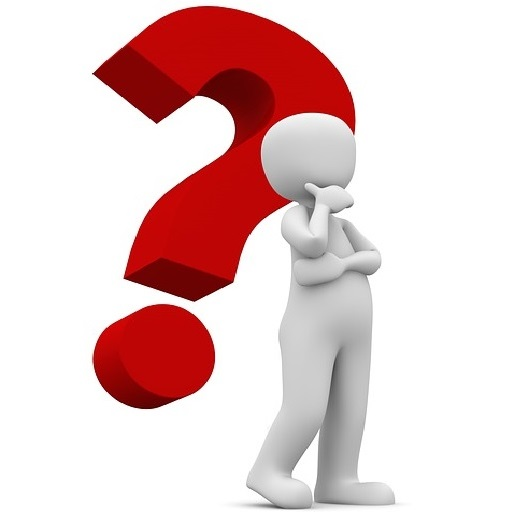
</div>

**Domanda 9**

Il modello è in grado di generare solo un nome per iniziale. Come si potrebbe modificare il modello per generare nomi diversi con la stessa iniziale?

<div>
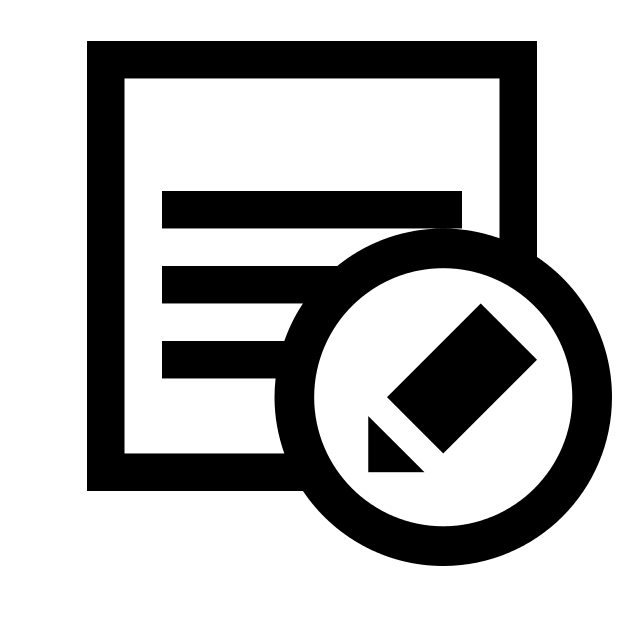
</div>

**Risposta 9**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

# 3 Traduzione (many to many)

Vediamo adesso un esempio di trasformazione many-to-many. Nello specifico, considereremo il problema di tradurre una frase da una lingua a un'altra. Costruiremo un modello basato su due RNN: un encoder, che "legge" la frase in input e la trasforma in un vettore a dimensione fissa detto "contesto" e un decoder, che viene inizializzata con il contesto prodotto dall'encoder e produce la frase in output in maniera simile a come la RNN precedentemente vista generava nomi. Se prima ci siamo posti il problema di generare le singole lettere di un nome, adesso vogliamo generare le parole di una frase, per cui considereremo una rappresentazione in cui ciascuna parola viene associata a un one-hot vector. Il modello proposto funziona come segue (immagine da https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html):

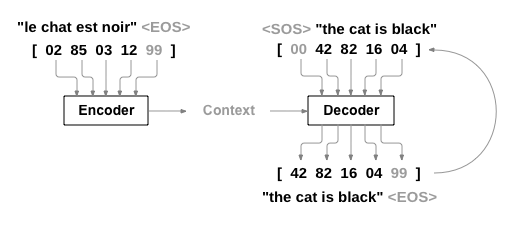

Come possiamo vedere dallo schema mostrato sopra, ciascuna parola viene mappata su un ID univoco, al quale corrisponderà un one-hot vector. Mentre il decoder "legge" le parole in input e produce solo un vettore di contesto alla fine della sequenza, il decoder sfrutta il metodo "autoregressivo" visto precedentemente in cui l'ultima parola generata viene passata in input al passo successivo. Dato che non forniamo una parola di inizio, oltre al carattere speciale `EOS`, considereremo un carattere `SOS` (Start Of Sequence). Iniziamo scaricando i dati presenti dal sito https://www.manythings.org/anki/:

`wget https://www.manythings.org/anki/ita-eng.zip`

`unzip ita-eng.zip`

Abbiamo estratto il file di testo `ita.txt`, che contiene coppie di frasi nelle lingue inglese e italiana separate da una tabulazione. Leggiamo il file:

In [39]:
with open('ita.txt','r') as f:
    lines = f.readlines()
eng = [l.split('\t')[0] for l in lines]
ita = [l.split('\t')[1] for l in lines]

Visualizziamo il numero di coppie totali e qualche coppia di frasi:

In [40]:
print(f"Coppie: {len(ita)}\n")
print(ita[0], '-', eng[0])
print(ita[10000], '-', eng[10000])
print(ita[300000], '-', eng[300000])
print(ita[350000], '-', eng[350000])

Coppie: 352040

Ciao! - Hi.
Sono malvagie. - They're evil.
Ha fatto i suoi compiti da solo? - Did you do your homework by yourself?
Giunse un rapporto che l'allunaggio dell'Apollo 11 era riuscito. - A report came in that Apollo 11 succeeded in landing on the moon.


Adesso dobbiamo trasformare le frasi in sequenze di entità riconducibili a degli ID distinti. Per fare ciò possiamo utilizzare un tokenizer. La libreria `spacy` ne mette a disposizione diversi. Installiamo la libreria con:

`pip install spacy`

Poi installiamo il supporto per le lingue italiana e inglese con:

`python -m spacy download it_core_news_sm`

`python -m spacy download en_core_web_sm`

Ora installiamo la libreria `torchtext` che permette di lavorare con il testo con PyTorch:

`pip install torchtext`

A questo punto possiamo definire i due tokenizer per le due lingue come segue:

In [41]:
from torchtext.data.utils import get_tokenizer
eng_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
ita_tokenizer = get_tokenizer('spacy', language='it_core_news_sm')

I tokenizer possono essere usati per suddividere una frase in token:

In [42]:
ita_tokenizer('Ciao sono io.')

['Ciao', 'sono', 'io', '.']

In [43]:
eng_tokenizer('Hello, is there anybody in there')

['Hello', ',', 'is', 'there', 'anybody', 'in', 'there']

<div>
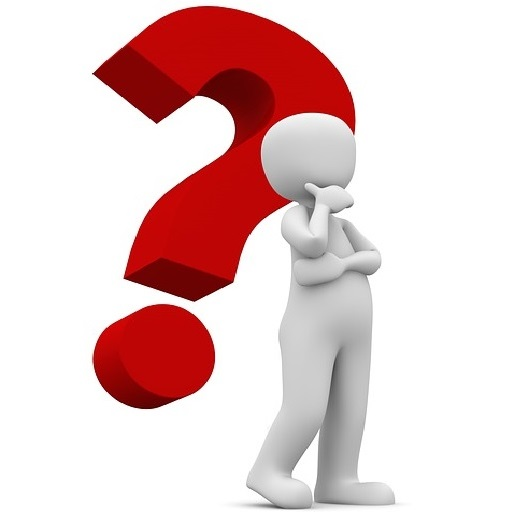
</div>

**Domanda 10**

Si confronti il risultato ottenuto sopra con quello di un algoritmo che considera i token come sequenze id caratteri separati da spazi. Il tokenizer fa qualcosa di più sofisticato?

<div>
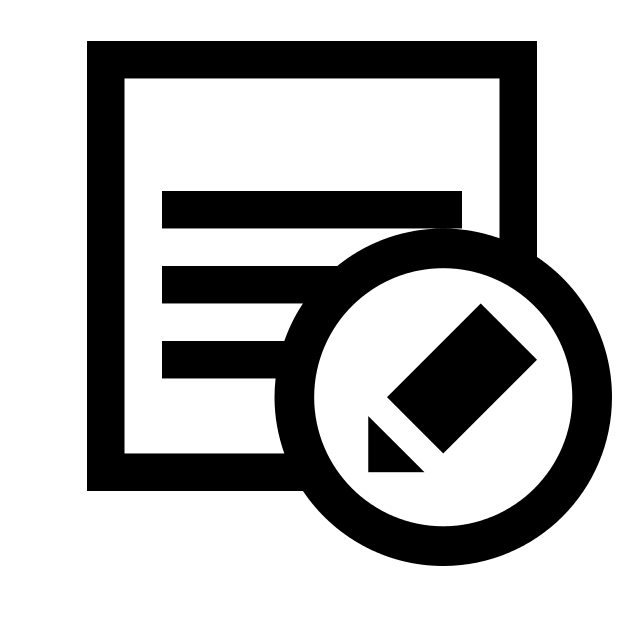
</div>

**Risposta 10**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Definiamo adesso dei token speciali che useremo per il nostro problema di traduzione:
 * `<unk>`: indica un token sconosciuto, ovvero una parola non appartenente al vocabolario che costruiremo a partire dai dati:
 * `<pad>`: indica un token usato per fare padding delle sequenze;
 * `<bos>`: beginning of sequence (equivalente a `SOS`);
 * `<eod>`: end of sequence.

Associeremo un id a ciascuno di questi token speciali:

In [44]:
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

Costruiamo adesso un iteratore che ci permetta di scorrere tutti i token presenti nei nostri dati:

In [70]:
def token_iterator(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

Possiamo adesso costruire un vocabolario per ciascuna lingua come segue:

In [72]:
from torchtext.vocab import build_vocab_from_iterator
vocab_transform_ita = build_vocab_from_iterator(token_iterator(ita, ita_tokenizer),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)
vocab_transform_eng = build_vocab_from_iterator(token_iterator(eng, eng_tokenizer),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

Impostiamo i token di default a `UNK_IDX`. In questo modo, se un token non viene trovato, verrà associato a questo indice:

In [75]:
vocab_transform_ita.set_default_index(UNK_IDX)
vocab_transform_eng.set_default_index(UNK_IDX)

Possiamo utilizzare i due oggetti "vocab_transform" per ottenre una lista di indici da una lista di token:

In [76]:
print(vocab_transform_ita(ita_tokenizer('Ciao sono io')))
print(vocab_transform_eng(eng_tokenizer('Is there anybody in there?')))

[4146, 21, 198]
[110, 98, 525, 19, 98, 9]


Da notare che se un token non viene trovato nel vocabolario, ad esso viene associato l'id 0:

In [77]:
print(vocab_transform_eng(eng_tokenizer('thris wold dos nnot exsist')))

[0, 0, 0, 0, 0]


Mettiamo adesso insieme quanto visto finora per creare un oggetto dataset che restituisca coppie input-output di frasi. L'oggetto dataset restituirà:
 
 * La sequenza degli indici dei token della frase in input all'encoder;
 * La sequenza degli indici dei token della frase in input al decoder;
 * La sequenza degli indici dei token della frase output del decoder;
 
Differentemente da quanto visto prima, non lavoreremo esplitamente con one-hot vectors, ma utilizzeremo dei layer di embedding all'interno del modello. Definiamo l'oggetto dataset:

In [78]:
class TranslationDataset(Dataset):
    def __init__(self, path_to_file='ita.txt', transform_ita=None, transform_eng=None, training = True, seed=42, test_size=0.7):
        with open('ita.txt','r') as f:
            lines = f.readlines()
            
        np.random.seed(seed)
        idx = np.random.permutation(len(lines))
        train_len = int(len(idx)*(1-test_size))
        if training:
            idx = idx[:train_len]
        else:
            idx = idx[train_len:]
            
        lines = np.array(lines)[idx]
        
        self.eng = [l.split('\t')[0] for l in lines]
        self.ita = [l.split('\t')[1] for l in lines]
        
        self.UNK_IDX, self.PAD_IDX, self.BOS_IDX, self.EOS_IDX = 0, 1, 2, 3
        self.special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']
        
        self.transform_ita = transform_ita
        self.transform_eng = transform_eng
        
    def __len__(self):
        return len(self.eng)

    def __getitem__(self, idx):
        ita = self.ita[idx]
        eng = self.eng[idx]
        
        if self.transform_ita:
            ita = self.transform_ita(ita)
        if self.transform_eng:
            eng = self.transform_eng(eng)
        
        encoder_input = torch.Tensor(ita + [self.EOS_IDX]).long()
        decoder_input = torch.Tensor([self.BOS_IDX] + eng).long()
        decoder_output = torch.Tensor(eng + [self.EOS_IDX]).long()
        
        return encoder_input, decoder_input, decoder_output

Definiamo l'oggetto training set usando delle trasformazioni composte che mettono in pipeline il tokenizer e la vocab transform di ciascuna lingua:

In [79]:
from torchvision import transforms
train_set = TranslationDataset(
    transform_ita = transforms.Compose([
        ita_tokenizer,
        vocab_transform_ita
    ]),
    transform_eng = transforms.Compose([
        eng_tokenizer,
        vocab_transform_eng
    ])
)

Visualizziamo un esempio di training:

In [80]:
train_set[0]

(tensor([  13,   28,  806, 9027,    9,  171,   15,  376,    4,    3]),
 tensor([   2,    5,   21,  123, 7723,   19,  763,   11,  352,    4]),
 tensor([   5,   21,  123, 7723,   19,  763,   11,  352,    4,    3]))

<div>
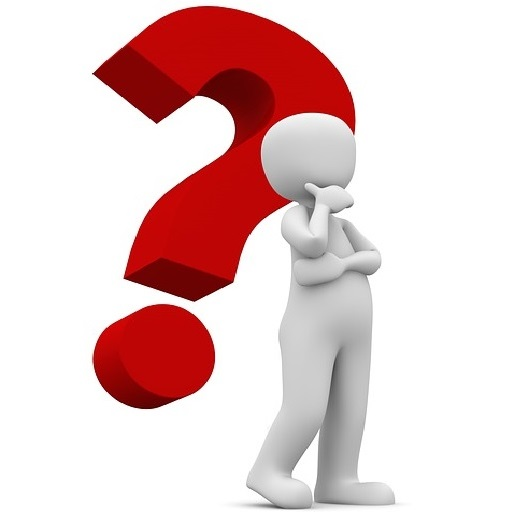
</div>

**Domanda 11**

Si analizzino le sequenze ottenute. I caratteri di inizio e fine sono corretti?

<div>
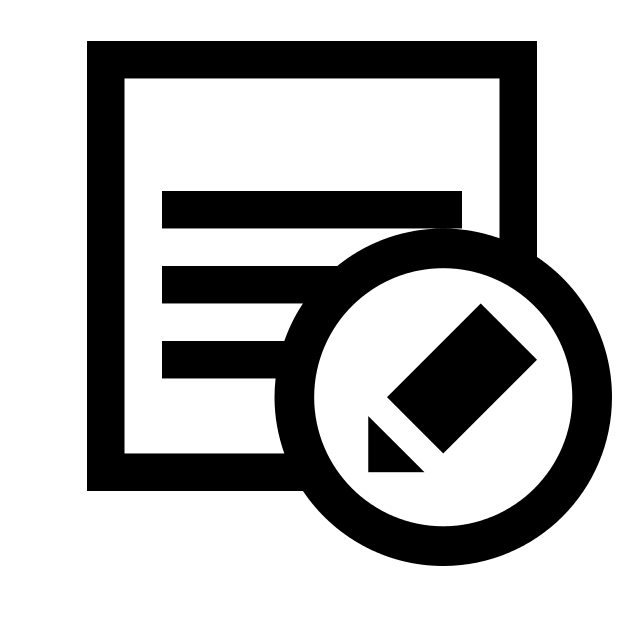
</div>

**Risposta 11**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Definiamo una funzione collate che faccia padding con il carattere di padding e dei dataloader:

In [81]:
def collate(elements):
    encoder_input = [e[0] for e in elements]
    decoder_input = [e[1] for e in elements]
    decoder_output = [e[2] for e in elements]
    
    encoder_input = pad_sequence(encoder_input, batch_first = True, padding_value=PAD_IDX)
    decoder_input = pad_sequence(decoder_input, batch_first = True, padding_value=PAD_IDX)
    decoder_output = pad_sequence(decoder_output, batch_first = True, padding_value=PAD_IDX)
    
    return encoder_input, decoder_input, decoder_output

test_set = TranslationDataset(
    transform_ita = transforms.Compose([
        ita_tokenizer,
        vocab_transform_ita,
    ]),
    transform_eng = transforms.Compose([
        eng_tokenizer,
        vocab_transform_eng
    ]),
    training=False
)

train_loader = DataLoader(train_set, shuffle=True, batch_size=256, collate_fn=collate, num_workers=2)
test_loader = DataLoader(test_set, batch_size=256, collate_fn=collate, num_workers=2)

Verifichiamo che il loader di training funzioni correttamente:

In [82]:
for batch in train_loader:
    print(batch[0])
    break

tensor([[9429,   44, 1083,  ...,    1,    1,    1],
        [ 186, 2493,    4,  ...,    1,    1,    1],
        [   5,  404, 2037,  ...,    1,    1,    1],
        ...,
        [ 102,  559,   18,  ...,    1,    1,    1],
        [1459,  121, 3148,  ...,    1,    1,    1],
        [ 116,   10, 2123,  ...,    1,    1,    1]])


<div>
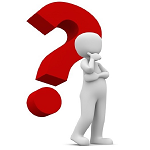
</div>

**Domanda 12**

Si analizzino le sequenze. Il padding è stato applicato in maniera corretta? Qual è l'indice di padding?

<div>
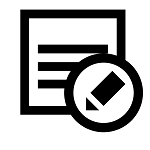
</div>

**Risposta 12**

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Definiremo adesso il nostro modello di rete neurale basato su due LSTM (un encoder e un decoder). Piuttosto che costruire i one-hot vector manualmente, utilizzeremo un layer di "embedding" che assocerà a ciascun id di token un vettore di rappresentazione. Definiamo il modello:

In [83]:
class TranslatorLSTM(nn.Module):
    def __init__(self,
                 num_input_tokens,
                 num_output_tokens,
                 padding_idx = PAD_IDX,
                 embedding_dim=128,
                 hidden_size=128
                ):
        super(TranslatorLSTM, self).__init__()
        
        # definiamo i layer di embedding
        # specifichiamo l'indice di padding. In questo modo, verrà restituito un embedding vector
        # costante formato da soli zeri, operazione che prima facevamo manualmente
        self.input_embedding = nn.Embedding(num_input_tokens, embedding_dim, padding_idx=padding_idx)
        self.output_embedding = nn.Embedding(num_output_tokens, embedding_dim, padding_idx=padding_idx)
        
        # definiamo encoder e decoder
        self.encoder = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        self.decoder = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        
        # definiamo un layer lineare "predictor" per predire i token
        self.predictor = nn.Linear(hidden_size, num_output_tokens)

    def forward(self, encoder_input, decoder_input):
        # prende in input encoder_input e decoder_input
        # questo è utile per il training
        
        encoder_input = self.input_embedding(encoder_input)
            
        # applichiamo l'encoder LSTM e conserviamo i vettori di stato e cella finali
        _, (h_encoder, c_encoder) = self.encoder(encoder_input)
        
        # se è stato definito l'output del decoder
        # effettuiamo il passaggio al decoder con una unica istruzione
        decoder_input = self.output_embedding(decoder_input)
        # passiamo l'input al decoder inizializzando hidden e cell vectors con quelli dell'encoder
        # conserviamo tutti gli hidden states
        hs_decoder, _ = self.decoder(decoder_input, (h_encoder, c_encoder))
        # otteniamo le predizioni finali dagli elementi decodificati
        output_predictions = self.predictor(hs_decoder)
        
        return output_predictions
    
    def translate(self, encoder_input, max_steps=100):
        # effettua una traduzione prendendo solo l'input del decoder
        encoder_input = self.input_embedding(encoder_input.unsqueeze(0))
        
        _, (h,c) = self.encoder(encoder_input)
        
        # prendiamo i vettori h e c all'ultimo timestep
        #h = h[:,-1,:].unsqueeze(1)
        #c = c[:,-1,:].unsqueeze(1)
        
        # applichiamo il decoder in maniera iterativa
        found_eos = False
        step = 0
        last_output = torch.Tensor([BOS_IDX]).long().view(1,-1)
        tokens = []
        while (not found_eos) and (step<max_steps):
            _, (h,c) = self.decoder(self.output_embedding(last_output), (h,c))
            last_output = self.predictor(h).argmax(-1) #otteniamo l'indice
            # se abbiamo trovato EOS
            if last_output==EOS_IDX:
                found_eos=True #termina il loop
            else:
                tokens.append(last_output.item()) #aggiungi il token alla lista
                step+=1
        return tokens

Instanziamo il modello e visualizziamo la shape dell'output per un possibile input:

In [84]:
model = TranslatorLSTM(num_input_tokens = len(vocab_transform_ita), num_output_tokens=len(vocab_transform_eng))
model(batch[0], batch[1]).shape

torch.Size([256, 46, 15263])

Proviamo adesso ad effettuare una traduzione. Il risultato sarà una sequenza di token:

In [85]:
batch[0][0]

tensor([9429,   44, 1083,    7, 3644,    4,    3,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1])

In [86]:
tokens = model.translate(batch[0][0])
tokens[:10]

[1377, 4675, 5202, 31, 10800, 3973, 3315, 7744, 7060, 1677]

Possiamo rimappare gli indici dei token nelle parole utilizzando il metodo `lookup_tokens` della `vocab_transform`:

In [87]:
print("Input:"," ".join(vocab_transform_ita.lookup_tokens(list(batch[0][0]))))
print()
print("Output:"," ".join(vocab_transform_eng.lookup_tokens(model.translate(batch[0][0]))))

Input: L'esercito era pieno di armi . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

Output: washing offering Cows for attaching buses coin intervened distrusted An nerd detonated snakes Disease talk Clinton I.D. vaccine Socrates Pianos Pianos earrings Handsome anticipates Lemons cogent fugitive graduated discontented warmly provided peeking Pork jewels hums effort currency sexist 1806 Ca rinsing impose shoveling expressway chilli Christianity Skiing relented Quote ordering sweats 27 conformist barrel him Guinea than 1930 unhappy Optimists dolphin Optimists snowing logic vehicles hoarse sunflower Count rosewood boarded edible emptied parents bury Order steaks Goodbye Fridays bleed transmitted dike problems distantly won enjoys trigger eyepatch contender overestimated cliche decorate see watchmen imagination risen

La traduzione non ha alcun senso perché il modello deve essere ancora allenato. Definiamo il modulo di PyTorch Lightning per effettuare il training:

In [88]:
class TranslationRNN(pl.LightningModule):
    def __init__(self, 
                 model,
                 lr=0.01, 
                 momentum=0.99):
        super(TranslationRNN, self).__init__()
        self.save_hyperparameters()
        
        self.model = model
        # usiamo la cross entropy
        # specifichiamo di ignorare le etichette pari a PAD_IDX
        self.criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX) 
                    
    def forward(self, input_encoder, input_decoder):
        return self.model(input_encoder, input_decoder)
        
    def configure_optimizers(self):
        return SGD(self.model.parameters(), self.hparams.lr, momentum=self.hparams.momentum)    
    
    def training_step(self, batch, batch_idx):
        input_encoder, input_decoder, output_decoder = batch
        
        
        predicted_output = self(input_encoder, input_decoder)
        
        loss = self.criterion(
            predicted_output.view(-1, predicted_output.shape[-1]), 
            output_decoder.view(-1)
        )
        
        acc = (predicted_output.view(-1, predicted_output.shape[-1]).argmax(-1).view(-1) == output_decoder.view(-1)).float().mean()
        
        self.log('train/loss', loss)
        self.log('train/acc', acc)
        return loss
    
    def validation_step(self, batch, batch_idx):
        input_encoder, input_decoder, output_decoder = batch
        
        predicted_output = self(input_encoder, input_decoder)
        
        loss = self.criterion(
            predicted_output.view(-1, predicted_output.shape[-1]), 
            output_decoder.view(-1)
        )
        
        acc = (predicted_output.view(-1, predicted_output.shape[-1]).argmax(-1).view(-1) == output_decoder.view(-1)).float().mean()
        
        self.log('val/loss', loss)
        self.log('val/acc', acc)
        return loss

Effettuiamo il training:

In [ ]:
translator_lstm = TranslatorLSTM(num_input_tokens = len(vocab_transform_ita), num_output_tokens=len(vocab_transform_eng))

translation_rnn = TranslationRNN(translator_lstm)

logger = TensorBoardLogger("rnn_logs", name="translator_lstm")
translator_lstm_trainer = pl.Trainer(max_epochs=200, gpus=1, logger=logger)
translator_lstm_trainer.fit(translation_rnn, train_loader, test_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | TranslatorLSTM   | 8.4 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
8.4 M     Trainable params
0         Non-trainable params
8.4 M     Total params
33.571    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/furnari/miniconda3/envs/dl/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/home/furnari/miniconda3/envs/dl/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Visualizziamo alcuni esempi di traduzione dal training set:

In [ ]:
def show_translation(input_tokens):
    output_tokens = translation_rnn.model.cpu().translate(input_tokens)
    print("Input:"," ".join(vocab_transform_ita.lookup_tokens(list(input_tokens))))
    print()
    print("Output:"," ".join(vocab_transform_eng.lookup_tokens(list(output_tokens))))

In [ ]:
for i in range(5):
    show_translation(train_set[i][0])
    print('---------------------------')

Vediamo adesso qualche esempio dal test set:

In [ ]:
for i in range(5):
    show_translation(test_set[i][0])
    print('---------------------------')

Come possiamo vedere, le traduzioni non sono accurate, ma il modello in genere produce frasi sensate. Ciò dipende in parte dalla semplicità del modello e in parte dal fatto che lo abbiamo allenato per poche epoche.

# Esercizi

<div>
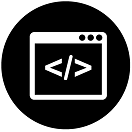
</div>

**Esercizio 1**

Si ripeta l'esperimento di training della RNN per la classificazione dei nomi utilizzando il modello di rete ricorrente GRU (https://pytorch.org/docs/stable/generated/torch.nn.GRU.html). Si ottimizzino gli iperparametri in modo da ottenere dei buoni risultati. Si confrontino i risultati ottenuti con quelli del modello RNN vanilla e della LSTM.

<div>
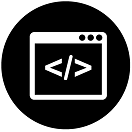
</div>

**Esercizio 2**

Si costruisca un modello basato su una LSTM che generi frasi a partire da una parola iniziale. Il modello può essere basato su quello usato per generare nomi, con la differenza che in questo caso verranno generati i token della frase. Si allenino due versioni del modello nelle lingue italiano e inglese.

<div>
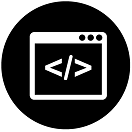
</div>

**Esercizio 3**

Si alleni una GRU per la traduzione dall'inglese allo spagnolo. Si faccia riferimento a questo sito per il download dei dati: https://www.manythings.org/anki/.

<div>
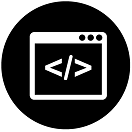
</div>

**Esercizio 4**

Si costruisca un modello LSTM capace di comprendere la lingua di una frase (si scelgano 10 lingue diverse). Il modello può essere basato su quello per la classificazione dei nomi, con la principale differenza che in questo caso verranno presi in input i token delle parole invece che i singoli caratteri del nome. Si faccia riferimento al seguente sito per il downoad dei dati: https://www.manythings.org/anki/.

<div>
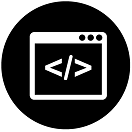
</div>

**Esercizio 5**

Si modifichi il modello costruito in precedenza per la generazione di frasi da una parola iniziale per funzionare in maniera multi-lingua. In maniera simile al modello per la predizione dei nomi, questo modello dovrà prendere in input l'ID della lingua oltre che la parola iniziale della frase.

<div>
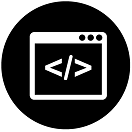
</div>

**Esercizio 6**

Allenare il modello di traduzione dall'italiano all'inglese per più epoche in modo da migliorare i risultati.

# References

 * Documentazione di PyTorch. http://pytorch.org/docs/stable/index.html
 * Documentazione di PyTorch Lightning. https://www.pytorchlightning.ai/
 * Tutorial su predizione nomi in PyTorch. https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial
 * Tutorial su generazione nomi in PyTorch. https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html
 * Articolo di blog di Andrej Karpathy. http://karpathy.github.io/2015/05/21/rnn-effectiveness/